## Training and Building the model(leafy crops)

In [2]:
pip install tensorflow matplotlib numpy

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/376.0 MB 9.6 MB/s eta 0:00:39
   ---------------------------------------- 3.1/376.0 MB 9.2 MB/s eta 0:00:41
   ---------------------------------------- 4.5/376.0 MB 9.9 MB/s eta 0:00:38
    --------------------------------------- 6.6/376.0 MB 10.1 MB/s eta 0:00:37
    --------------------------------------- 8.9/376.0 MB 9.4 MB/s eta 0:00:40
   - -------------------------------------- 11.0/376.0 MB 9.4 MB/s eta 0:00:39
   - -------------------------------------- 13.4/376.0 MB 9.8 MB/s eta 0:00:38
   - -------------------------------------- 15.7/376.0 MB 9.8 MB/s eta 0:00:37
   - -------------------------------------- 18.1/376.0 MB 10.0 MB/s eta 0:00:36
   -- ------------------------------------- 19.9/376.0 MB 9.9 MB/s eta 0:00:36
   -- ------------------------------------- 21.0/376.0 MB 9.3 MB/s eta 0:00:39
   -- ------------------------------------- 22.0/376.0 MB 9.0 M

------------------------------------------------

In [3]:
import tensorflow as tf 
import numpy
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### loading dataset


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/leafy_crops",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2337 files belonging to 8 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial',
 'Downy_mildew_on_lettuce',
 'Healthy',
 'Powdery_mildew_on_lettuce',
 'Septoria_blight_on_lettuce',
 'Shepherd_purse_weeds',
 'Viral',
 'Wilt_and_leaf_blight_on_lettuce']

#### Previewing the data

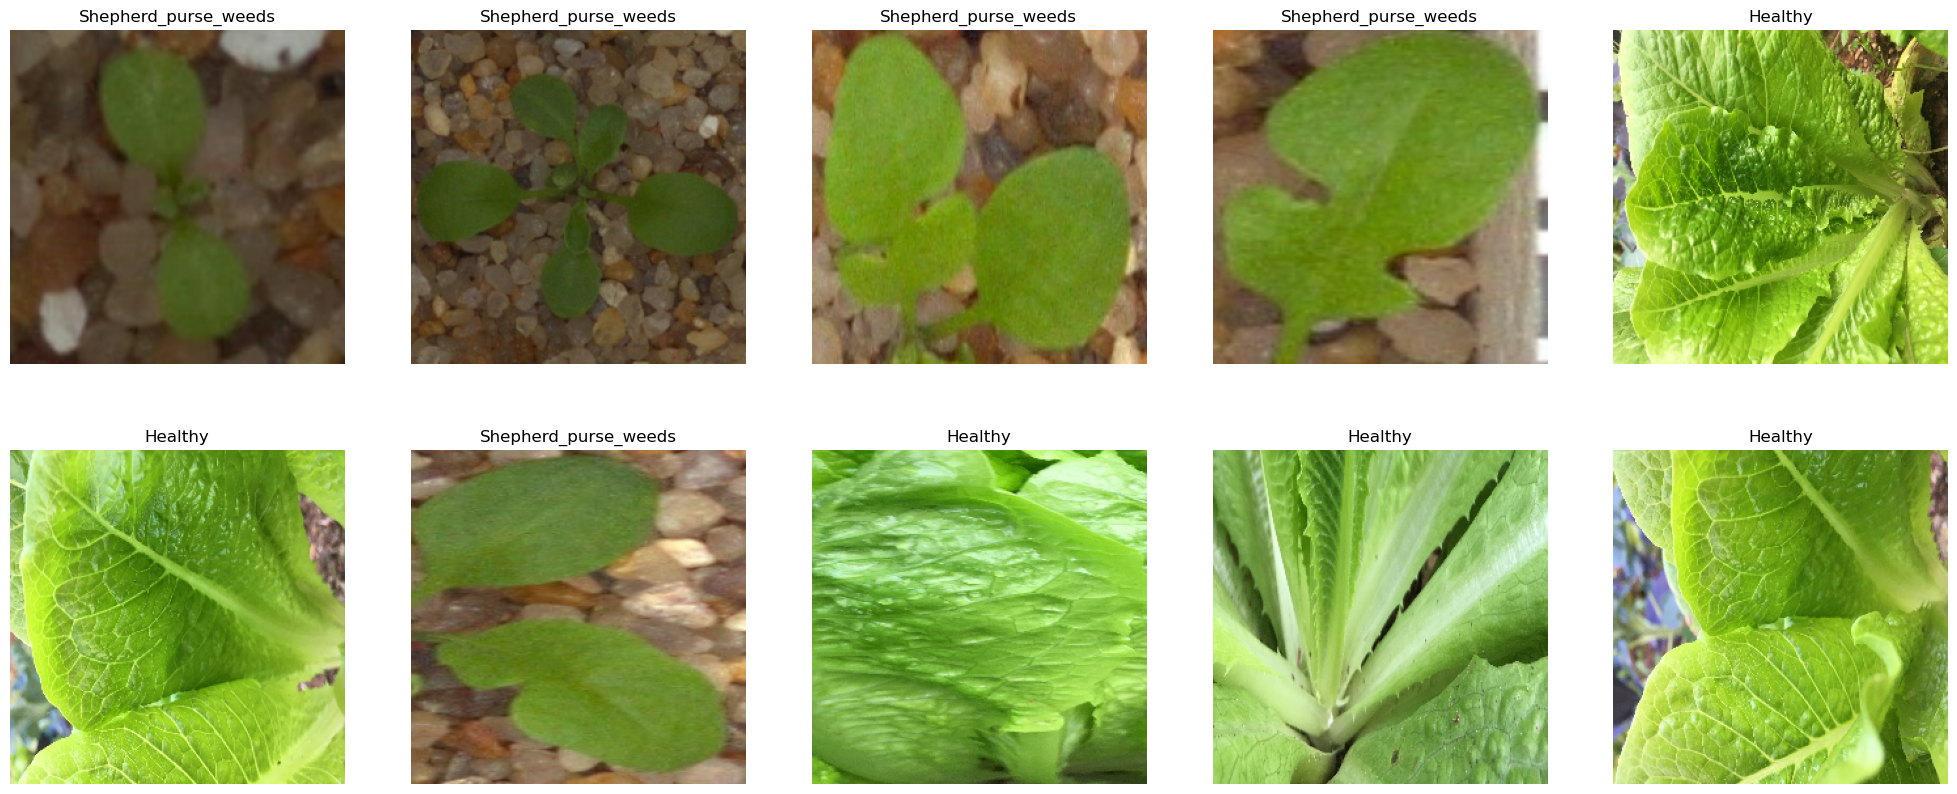

In [7]:
plt.figure(figsize=(25,10))
for img_batch, label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

#### Total Data 
*Split Dataset into these sets*
1. Training Data (80%)
2. Validation Data (10%)
3. Testing Data (10%)

In [8]:
def partition_data(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=100000):
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    dataset_len = len(ds)

    train_size = int(train_split * dataset_len)
    val_size = int(val_split * dataset_len)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [9]:
train_ds, val_ds, test_ds = partition_data(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation

In [12]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE,IMAGE_SIZE),
    Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

In [14]:
from tensorflow.keras import models,layers

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Kritagya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 8)                     │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,072 (719.03 KB)

 Trainable params: 184,072 (719.03 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9227 - loss: 0.4129 - val_accuracy: 0.9643 - val_loss: 0.1828
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 987ms/step - accuracy: 0.9513 - loss: 0.2361 - val_accuracy: 0.9643 - val_loss: 0.1660
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 983ms/step - accuracy: 0.9486 - loss: 0.2306 - val_accuracy: 0.9643 - val_loss: 0.1376
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 983ms/step - accuracy: 0.9487 - loss: 0.1770 - val_accuracy: 0.9598 - val_loss: 0.1489
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 978ms/step - accuracy: 0.9627 - loss: 0.1461 - val_accuracy: 0.9643 - val_loss: 0.1172
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 974ms/step - accuracy: 0.9617 - loss: 0.1466 - val_accuracy: 0.9643 - val_loss: 0.1567
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 983ms/step - accuracy: 0.9528 - loss: 0.1851 - val_accuracy: 0.9643 - val_loss: 0.1286
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 974ms/step - accuracy: 0.9559 - loss: 0.1539 - val_accurac

In [22]:
model.evaluate(test_ds)

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_7076]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [40]:
EPOCHS=30

Text(0.5, 1.0, 'Training and Validation Loss')

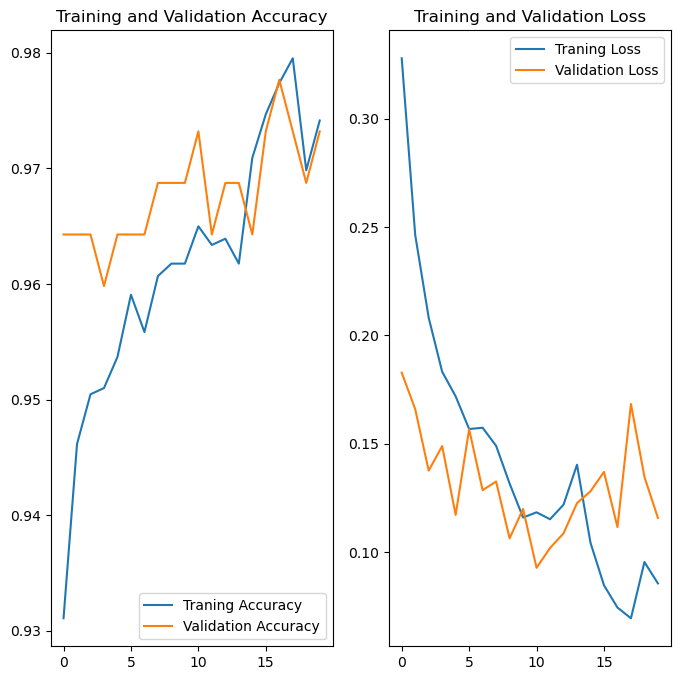

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Traning Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Traning Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [25]:
import numpy as np

first image to predict:
first image actual label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
first image predicted label: Healthy


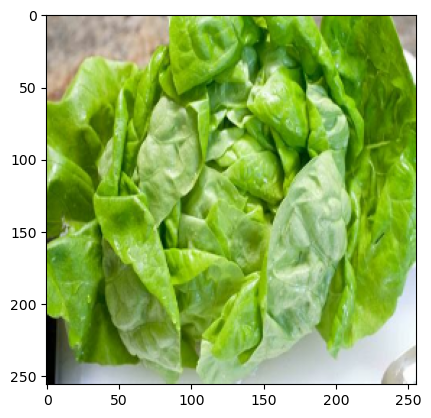

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict:")
    plt.imshow(first_image)
    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("first image predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(np.argmax(batch_prediction[0]))



In [45]:
model.save("models/leafy.keras")